In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow as tf
import json
import os
import sys
import cv2
import yaml
import numpy as np
from tensorflow.python.keras import backend as K
p = os.path.abspath('.')
sys.path.insert(1, p)
from models.lenet5Autoencode import LeNet
from data_import_and_preprocessing.dataset_formation import DataParser, ImageDataExtractor, LabelExtractor, \
    DataSetCreator
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-28 20:03:29.104163: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


"initialize Dataset and training params from params.yml"

In [2]:
print(os.getcwd())
os.chdir('/mnt/0A60B2CB60B2BD2F/Projects/leo_flow_regime_recognition')
print(os.getcwd())
with open('params.yaml', 'r') as stream:
    params = yaml.safe_load(stream)
    no_epochs = params['training']['no_epochs']
    batch_size = params['training']['batch_size']
    loss = params['training']['loss']
    picture_width = params['preprocessing']['picture_width']
    picture_hight = params['preprocessing']['picture_hight']
    no_classes = params['preprocessing']['no_classes']

    data_dir = 'data/preprocessed'
    data_parser = DataParser(data_dir)
    image_data_extractor = ImageDataExtractor((picture_width, picture_hight, 1))
    label_extractor = LabelExtractor(no_classes=no_classes) #anzahl der classen
    dataset = DataSetCreator(data_parser, image_data_extractor, label_extractor, no_repeats=no_epochs)
    no_points = len(dataset)
    no_points_train = int(no_points * 0.8)
    no_points_val = int(no_points * 0.1)

    dataset_train = dataset.take(no_points=no_points_train)

/mnt/0A60B2CB60B2BD2F/Projects/leo_flow_regime_recognition/inference
/mnt/0A60B2CB60B2BD2F/Projects/leo_flow_regime_recognition


2022-06-28 20:03:35.083590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 20:03:35.733490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5402 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:18:00.0, compute capability: 7.5


## load model

In [3]:
model_path = "/mnt/0A60B2CB60B2BD2F/Projects/leo_flow_regime_recognition/training/model/trained_model.h5"
reconstructed_model = tf.keras.models.load_model(model_path)

## load img and infer class label

In [4]:
path = '/mnt/0A60B2CB60B2BD2F/Projects/leo_flow_regime_recognition/data/preprocessed/1100000001.png'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)
img_preprocessed  = img / 255

x = np.expand_dims(img_preprocessed, axis=0)


preds = reconstructed_model.predict(x)

2022-06-28 20:03:36.861358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-06-28 20:03:37.376166: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


1/1 [==============================] - 2s 2s/step


## pretty the prediction for console output

In [5]:
pred=np.around(preds,3)
i=0
inferedClass=""
classaccuracy=0

inferedAccuracyFlooded=0
inferedAccuracyLoaded=0
inferedAccuracyDispersed=0

for v in pred[0]:
    if i==0:
        inferedAccuracyFlooded = v
    if i==1:
        inferedAccuracyLoaded = v
    if i==2:
        inferedAccuracyDispersed = v
    i=i+1
classaccuracy = max(inferedAccuracyFlooded,inferedAccuracyDispersed,inferedAccuracyLoaded)
if classaccuracy == inferedAccuracyFlooded:
    inferedClass= "Flooded"
if classaccuracy == inferedAccuracyLoaded:
    inferedClass= "Loaded"
if classaccuracy == inferedAccuracyDispersed:
    inferedClass= "Despersed"
print(inferedClass+": "+str(classaccuracy))

Flooded: 0.999


## get dense autoencode auxilary putput

In [6]:
reconstructed_model.layers[11].output
autoencodeLayer = K.function([reconstructed_model.layers[0].input], [reconstructed_model.layers[11].output])
autoencodeLayer_output = autoencodeLayer(x)[0]
autoencodeLayer_output

array([[-57.807453,  10.693283]], dtype=float32)

## asign Points

In [7]:
from data_import_and_preprocessing.dataset_formation import DataParser, ImageDataExtractor, LabelExtractor, \
    DataSetCreator

print(os.getcwd())
os.chdir('/mnt/0A60B2CB60B2BD2F/Projects/leo_flow_regime_recognition')
print(os.getcwd())
with open('params.yaml', 'r') as stream:
    params = yaml.safe_load(stream)
no_epochs = params['training']['no_epochs']
batch_size = params['training']['batch_size']
picture_width = params['preprocessing']['picture_width']
picture_hight = params['preprocessing']['picture_hight']
no_classes = params['preprocessing']['no_classes']

data_dir = 'data/preprocessed'
data_parser = DataParser(data_dir)
image_data_extractor = ImageDataExtractor((picture_width, picture_hight, 1))
label_extractor = LabelExtractor(no_classes=no_classes) #anzahl der classen
dataset = DataSetCreator(data_parser, image_data_extractor, label_extractor, no_repeats=no_epochs)
pathList = []
for imagePath in dataset.data_points:
    pathList.append(imagePath.path_to_data)

/mnt/0A60B2CB60B2BD2F/Projects/leo_flow_regime_recognition
/mnt/0A60B2CB60B2BD2F/Projects/leo_flow_regime_recognition


In [8]:
from models.lenet5Autoencode import LeNet

#Create a clustering model
points_n = 200
clusters_n = 3
iteration_n = 100

model = LeNet

points = tf.constant(np.random.uniform(0, 10, (points_n, 2)))

In [9]:
points

<tf.Tensor: shape=(200, 2), dtype=float64, numpy=
array([[8.70110121, 1.28253794],
       [4.69954951, 3.28160286],
       [5.90212486, 3.8803889 ],
       [4.88482089, 6.1665389 ],
       [5.09070501, 5.52621182],
       [3.27523305, 3.48483219],
       [3.23213632, 0.08859406],
       [3.34313251, 8.69349635],
       [5.96119309, 2.20226008],
       [2.25613342, 6.75710026],
       [0.84288169, 8.27230655],
       [0.54522095, 4.82398021],
       [4.30579027, 1.29084972],
       [9.18798763, 6.21219793],
       [5.05638562, 8.36076035],
       [6.73652374, 4.78826689],
       [8.99025292, 4.30978937],
       [4.8746782 , 8.43155567],
       [4.23413013, 4.85351229],
       [2.63855926, 6.99225915],
       [7.8080841 , 3.34101108],
       [6.92544462, 2.72026321],
       [5.83455921, 0.16724449],
       [8.16191823, 2.91620296],
       [7.24058394, 7.59554483],
       [0.74267114, 1.1587399 ],
       [6.44093837, 2.87301836],
       [8.40765616, 7.86830973],
       [3.32392964, 5.3904

In [10]:

centroids = tf.Variable(tf.slice(tf.random.shuffle(points), [0, 0], [clusters_n, -1]))

points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)

distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)

means = []
for c in range(clusters_n):
    means.append(tf.reduce_mean(
      tf.gather(points,
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),[1]))

new_centroids = tf.concat(means, 0)

update_centroids =  tf.compat.v1.assign(centroids, new_centroids)
init = tf.compat.v1.global_variables_initializer()



## init clustering

In [11]:
centroids = tf.Variable(tf.slice(tf.random.shuffle(points), [0, 0], [clusters_n, -1]))

points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)

distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)

means = []
for c in range(clusters_n):
    means.append(tf.reduce_mean(
      tf.gather(points,
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),[1]))

new_centroids = tf.concat(means, 0)

update_centroids =  tf.compat.v1.assign(centroids, new_centroids)
init = tf.compat.v1.global_variables_initializer()

## Build clusters and display results

centroids <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[1.37837409, 2.46519323],
       [4.95193301, 7.88310759],
       [6.22068664, 2.9483463 ]])>
centroids <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[1.37837409, 2.46519323],
       [4.95193301, 7.88310759],
       [6.22068664, 2.9483463 ]])>
centroids <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[1.37837409, 2.46519323],
       [4.95193301, 7.88310759],
       [6.22068664, 2.9483463 ]])>
centroids <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[1.37837409, 2.46519323],
       [4.95193301, 7.88310759],
       [6.22068664, 2.9483463 ]])>
centroids <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[1.37837409, 2.46519323],
       [4.95193301, 7.88310759],
       [6.22068664, 2.9483463 ]])>
centroids <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[1.37837409, 2.46519323],
       [4.95193301, 7.88310759],
   

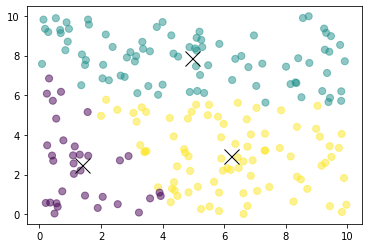

In [12]:
for step in range(iteration_n):
    [_, centroid_values, points_values, assignment_values] = [update_centroids, centroids, points, assignments]

    print("centroids", centroid_values)

plt.scatter(points_values[:, 0], points_values[:, 1], c=assignment_values, s=50, alpha=0.5)
plt.plot(centroid_values[:, 0], centroid_values[:, 1], 'kx', markersize=15)
plt.show()